In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image # for image processing and loading
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset 
# DataLoader is for loading data in batches
# TensorDataset is for custom dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms


In [2]:
torch.manual_seed(777)
IMAGE_SIZE = 128 # 훈련 시키려면 이미지 크기를 통일 시켜야함. 128x128로 통일

device='cuda' if torch.cuda.is_available() else 'cpu'
if device=='cuda':
    torch.cude.manual_seed_all(777)

In [3]:
test_dataset = ImageFolder(root='test_image/',
                            transform=transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor(),
                            ]))

In [4]:
test_loader = DataLoader(test_dataset, 
                         batch_size=10, 
                         shuffle=False, 
                         num_workers=1)

In [6]:
test_images, labels=next(iter(test_loader))
print(test_images.size(), labels.size())
print(labels)

torch.Size([10, 3, 128, 128]) torch.Size([10])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


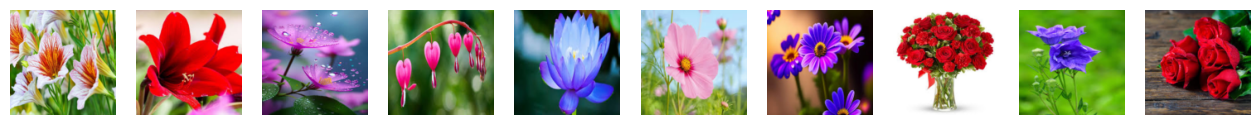

In [7]:
# 이미지 출력

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].permute(1, 2, 0)) 
    # 행, 열, 채널 순서로 이미지 출력
    plt.axis('off')
plt.show()

In [9]:
# CNN 모델 정의

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        # conv1: 입력(3, 128, 128) 
        self.conv1=nn.Conv2d( 
                   in_channels=3,
                   out_channels=8,
                     kernel_size=3,
                        stride=1,
                        padding=1
                        )
        # conv2: 입력(8, 128, 128) 
        self.conv2=nn.Conv2d( 
                        in_channels=8,
                        out_channels=16,
                        kernel_size=3,
                        stride=1,
                        padding=1
                        )
        # conv3: 입력(16, 64, 64)
        self.conv3=nn.Conv2d(
                        in_channels=16,
                        out_channels=32,
                        kernel_size=3,
                        stride=1,
                        padding=1
                        )
        # conv4: 입력(32, 32, 32)
        self.conv4=nn.Conv2d(
                        in_channels=32,
                        out_channels=64,
                        kernel_size=3,
                        stride=1,
                        padding=1
                        )
        
        # conv5: 입력(64, 16, 16)
        self.conv5=nn.Conv2d(
                        in_channels=64,
                        out_channels=128,
                        kernel_size=3,
                        stride=1,
                        padding=1
                        )
        



        # maxpooling
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1=nn.Linear(128*4*4, 128) # fully connected layer. 128 설정 이유
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64, 5) # 5개의 클래스로 분류 

    def forward(self, x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.pool(x) # (8, 64, 64)
        x=self.conv2(x)
        x=torch.relu(x)
        x=self.pool(x) # (16, 32, 32)
        x=self.conv3(x)
        x=torch.relu(x)
        x=self.pool(x) # (32, 16, 16)
        x=self.conv4(x)
        x=torch.relu(x)
        x=self.pool(x) # (64, 8, 8)
        x=self.conv5(x)
        x=torch.relu(x)
        x=self.pool(x) # (128, 4, 4)

        # 특징 추출
        x=x.view(-1, 128*4*4) # 128*4*4로 flatten. -1 -> batch size: 100
        #분류
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=torch.softmax(x, dim=1) # softmax를 통해 확률값으로 변환
        return x 

In [10]:
model2=CNN().to(device)
model2.load_state_dict(torch.load('model.pt'))
model2.eval()

C:\Users\it\AppData\Local\Temp\ipykernel_16480\1862611558.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model.pt'))


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

In [11]:
predict=model2(test_images.to(device)).argmax(dim=1)
print(predict)


tensor([4, 2, 4, 4, 2, 4, 4, 2, 4, 2])


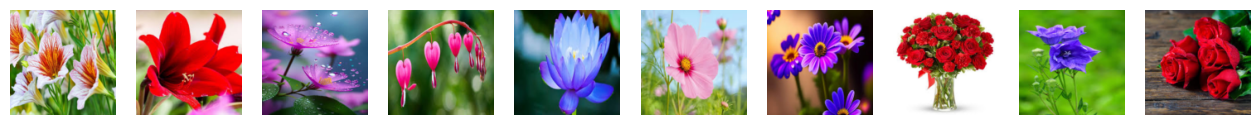

In [12]:
plt.figure(figsize=(16, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].permute(1, 2, 0)) 
    # 행, 열, 채널 순서로 이미지 출력
    plt.axis('off')
plt.show()